# Poisson-Gamma model

See Mohler et al, *Reducing Bias in Estimates for the Law of Crime Concentration* J.Quantitative Criminology, 2019 https://doi.org/10.1007/s10940-019-09404-1

In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import gamma, nbinom

from utils import CATEGORIES, extract_crime_data, get_lsoa_boundaries, monthgen

In [ ]:
rng = np.random.default_rng(19937)

CATEGORY = CATEGORIES[1]
crime_data = extract_crime_data("./data/wy202204-202503.zip")
# filter by catgegory and remove any points
crime_data = crime_data[(crime_data["Crime type"] == CATEGORY)]
crime_data

Month  \
Crime ID                                                      
cde2b5f3ded5c85add5aafdb536bdfe31ecf3dae4399b4d...  2022-04   
95aaf13495d017cde7ad486e4e57b2899c1b1c16b28b953...  2022-04   
bbe61d934f89b85f42e2e6a812706779a9ed8a0106d3dd8...  2022-04   
259057f8d09ba2423f3f1cee456240754eb2cb27b9ace24...  2022-04   
10b856f1e9d9b4ece555be9ad38198ec7745ca421a383f6...  2022-04   
...                                                     ...   
a13de3868acbdb6b12499c6225a035dc8f1bcd8b82bdc6b...  2025-03   
6d2686d2eb6df343e68490dbf6cb11721a8a764c2baad2f...  2025-03   
507aef1dcc104d4c02d6dc1fccc305eea596477b6657229...  2025-03   
ad2a3d4463dcecd01a77ed9cb0a4b131fd921efaa7974e2...  2025-03   
6c634b40b5435bd27b3ac5a183bbd2193ec5b94f7e74a88...  2025-03   

                                                              Reported by  \
Crime ID                                                                    
cde2b5f3ded5c85add5aafdb536bdfe31ecf3dae4399b4d...  West Yorkshire Police   
95aaf13495d017cde7ad486e4e57b2899c1b1c16b28b953...  West Yorkshire Police   
bbe61d934f89b85f42e2e6a812706779a9ed8a0106d3dd8...  West Yorkshire Police   
259057f8d09ba2423f3f1cee456240754eb2cb27b9ace24...  West Yorkshire Police   
10b856f1e9d9b4ece555be9ad38198ec7745ca421a383f6...  West Yorkshire Police   
...                                                                   ...   
a13de3868acbdb6b12499c6225a035dc8f1bcd8b82bdc6b...  West Yorkshire Police   
6d2686d2eb6df343e68490dbf6cb11721a8a764c2baad2f...  West Yorkshire Police   
507aef1dcc104d4c02d6dc1fccc305eea596477b6657229...  West Yorkshire Police   
ad2a3d4463dcecd01a77ed9cb0a4b131fd921efaa7974e2...  West Yorkshire Police   
6c634b40b5435bd27b3ac5a183bbd2193ec5b94f7e74a88...  West Yorkshire Police   

                                                             Falls within  \
Crime ID                                                                    
cde2b5f3ded5c85add5aafdb536bdfe31ecf3dae4399b4d...  West Yorkshire Police   
95aaf13495d017cde7ad486e4e57b2899c1b1c16b28b953...  West Yorkshire Police   
bbe61d934f89b85f42e2e6a812706779a9ed8a0106d3dd8...  West Yorkshire Police   
259057f8d09ba2423f3f1cee456240754eb2cb27b9ace24...  West Yorkshire Police   
10b856f1e9d9b4ece555be9ad38198ec7745ca421a383f6...  West Yorkshire Police   
...                                                                   ...   
a13de3868acbdb6b12499c6225a035dc8f1bcd8b82bdc6b...  West Yorkshire Police   
6d2686d2eb6df343e68490dbf6cb11721a8a764c2baad2f...  West Yorkshire Police   
507aef1dcc104d4c02d6dc1fccc305eea596477b6657229...  West Yorkshire Police   
ad2a3d4463dcecd01a77ed9cb0a4b131fd921efaa7974e2...  West Yorkshire Police   
6c634b40b5435bd27b3ac5a183bbd2193ec5b94f7e74a88...  West Yorkshire Police   

                                                                          Location  \
Crime ID                                                                             
cde2b5f3ded5c85add5aafdb536bdfe31ecf3dae4399b4d...       On or near Mount Pleasant   
95aaf13495d017cde7ad486e4e57b2899c1b1c16b28b953...    On or near Bus/Coach Station   
bbe61d934f89b85f42e2e6a812706779a9ed8a0106d3dd8...  On or near Back Middleton Road   
259057f8d09ba2423f3f1cee456240754eb2cb27b9ace24...          On or near Supermarket   
10b856f1e9d9b4ece555be9ad38198ec7745ca421a383f6...      On or near Back Grove Road   
...                                                                            ...   
a13de3868acbdb6b12499c6225a035dc8f1bcd8b82bdc6b...          On or near Edna Street   
6d2686d2eb6df343e68490dbf6cb11721a8a764c2baad2f...        On or near Burton Street   
507aef1dcc104d4c02d6dc1fccc305eea596477b6657229...         On or near Parking Area   
ad2a3d4463dcecd01a77ed9cb0a4b131fd921efaa7974e2...      On or near Holmsley Avenue   
6c634b40b5435bd27b3ac5a183bbd2193ec5b94f7e74a88...         On or near Clayton View   

                                                    LSOA code       LSOA name  \
Crime ID                      

In [4]:
lsoa_boundaries = get_lsoa_boundaries("GC", overlapping=crime_data)

In [6]:
counts = (
    crime_data.groupby(["Month", "LSOA code"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
)
counts

Month      2022-04  2022-05  2022-06  2022-07  2022-08  2022-09  2022-10  \
LSOA code                                                                  
E01005448        0        0        0        0        0        0        0   
E01007328        0        0        0        0        0        0        0   
E01007329        0        0        0        0        0        0        0   
E01007359        0        0        0        0        0        1        0   
E01007418        0        0        1        0        0        0        0   
...            ...      ...      ...      ...      ...      ...      ...   
E01035050        0        0        0        0        0        0        0   
E01035051        0        0        0        0        0        0        0   
E01035052        0        0        2        0        0        1        0   
E01035053        0        0        0        0        0        0        0   
E01035054        0        0        0        0        0        0        0   

Month      2022-11  2022-12  2023-01  ...  2024-06  2024-07  2024-08  2024-09  \
LSOA code                             ...                                       
E01005448        1        0        0  ...        0        0        0        0   
E01007328        0        0        0  ...        0        0        0        0   
E01007329        1        0        0  ...        0        0        0        0   
E01007359        0        0        0  ...        0        0        0        0   
E01007418        0        0        0  ...        0        0        0        0   
...            ...      ...      ...  ...      ...      ...      ...      ...   
E01035050        0        0        0  ...        1        1        1        2   
E01035051        0        0        0  ...        1        1        0        0   
E01035052        0        0        0  ...        1        1        0        2   
E01035053        0        0        0  ...        0        4        3        1   
E01035054        0        0        0  ...        2        5        3        4   

Month      2024-10  2024-11  2024-12  2025-01  2025-02  2025-03  
LSOA code                                                        
E01005448        0        0        0        0        0        0  
E01007328        0        0        0        0        0        0  
E01007329        0        0        0        0        0        0  
E01007359        0        0        1        0        0        0  
E01007418        0        0        0        0        0        0  
...            ...      ...      ...      ...      ...      ...  
E01035050        0        2        0        0        0        0  
E01035051        1        0        0        1        0        0  
E01035052        0        0        0        0        0        0  
E01035053        0        0        0        0        0        0  
E01035054        5        3        3        3        1        2  

[1438 rows x 36 columns]

In [ ]:
def simple_nbinom_fit(sample: list[int]) -> tuple[float, float]:
    mu = np.mean(sample)
    sigma2 = np.var(sample)
    if mu >= sigma2:
        return np.nan, np.nan
    n = mu**2 / (sigma2 - mu)
    p = mu / sigma2
    return n, p


def wrap_fit(row: pd.Series) -> pd.Series:
    n, p = simple_nbinom_fit(row.tolist())
    return pd.Series({"n": n, "p": p})


def nbinom_fit(sample: pd.Series):
    sample.name = "nbdata"
    # Dispersion parameter from nb model with only interaction term
    nbfit = smf.negativebinomial("nbdata ~ 1", data=sample.to_frame()).fit()
    mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
    alpha = nbfit.params[1]  # Dispersion parameter
    var = mu + alpha * mu**2
    p = mu / var
    n = mu**2 / (var - mu)
    return pd.Series({"n": n, "p": p})

In [ ]:
model_params = counts.apply(nbinom_fit, axis=1)
model_params

Optimization terminated successfully.
         Current function value: 0.127328
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.290414
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.127328
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.216140
         Iterations: 9
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.290414
         Iterations: 10
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.216140
         Iterations: 9
         Function evaluations: 13
      

/home/az/dev/safer-streets/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/home/az/dev/safer-streets/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionW

Optimization terminated successfully.
         Current function value: 1.990327
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.384005
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.034815
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.377279
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 2.315015
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.662322
         Iterations: 8
         Function evaluations: 9
         Gradi

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.298854
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.556468
         Iterations: 12
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 1.677809
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.385108
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.500005
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.454832
         Iterations: 16
         Function evaluations: 17
         

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/home/az/dev/safer-streets/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is depreca

Optimization terminated successfully.
         Current function value: 1.332633
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.618443
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.730621
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.521531
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.561875
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 2.126360
         Iterations: 10
         Function evaluations: 11
     

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.168342
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.514278
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.061521
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.636811
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.183411
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.597707
         Iterations: 8
         Function evaluations: 9
         Gradien

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.324969
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.520470
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.911792
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.915604
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.008345
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.783085
         Iterations: 6
         Function evaluations: 7
        

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.738092
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.190423
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.077827
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.504735
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.757950
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.090982
         Iterations: 6
         Function evaluations: 7
         Gradient

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.243328
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 2.020286
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.898340
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.424389
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.777546
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.954711
         Iterations: 5
         Function evaluations: 7
         Gradi

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.537684
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.509101
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.989127
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.773186
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.112749
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 1.979524
         Iterations: 7
         Function evaluations: 8
       

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.131063
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.593948
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.778261
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.144343
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.185316
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 3.477292
         Iterations: 7
         Function evaluations: 8
         G

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.277669
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.963955
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.082861
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.886087
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.084044
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.966776
         Iterations: 7
         Function evaluations: 9
         Gradien

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.096973
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.321789
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.895563
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 1.493436
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.410801
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 2.419275
         Iterations: 5
         Function evaluations: 6
        

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.699694
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.190946
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.615837
         Iterations: 11
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 1.464612
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.969838
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.800705
         Iterations: 14
         Function evaluations: 16
      

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.068779
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.545984
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.232754
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.940700
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.846691
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.542135
         Iterations: 14
         Function evaluations: 15
         Gradi

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.205617
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.419455
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.856769
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.219492
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.499116
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.011579
         Iterations: 6
         Function evaluations: 8
         Gradi

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.281434
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.421428
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.539647
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.083952
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.455118
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.034649
         Iterations: 7
         Function evaluations: 9
         Grad

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.014050
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.607302
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.942235
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 1.606472
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.820722
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.996698
         Iterations: 7
         Function evaluations: 8
         Grad

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.121403
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.558788
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.131063
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.631493
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.335904
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.591489
         Iterations: 7
         Function evaluations: 8
         Gr

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.056828
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.701582
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.410014
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.799062
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.715644
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.885808
         Iterations: 7
         Function evaluations: 8
         Grad

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.601467
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.911792
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.259307
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.120650
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.906999
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.884300
         Iterations: 14
         Function evaluations: 16
         Gra

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.193409
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.638141
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.167035
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.521026
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.095869
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.354760
         Iterations: 9
         Function evaluations: 10
         Gradie

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.614681
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.200237
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.448183
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.093716
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 2.164975
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 1.657328
         Iterations: 7
         Function evaluations: 8
         Gr

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 0.947358
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.529990
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.970388
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.283715
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.489706
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.952441
         Iterations: 5
         Function evaluations: 7
         Grad

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 1.143615
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 1.367192
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.819963
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.986032
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.389827
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 1.298552
         Iterations: 8
         Function evaluations: 10
      

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

Optimization terminated successfully.
         Current function value: 2.874098
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.983920
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.916048
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.059714
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.328163
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 1.153912
         Iterations: 5
         Function evaluations: 6
         Gradien

/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/966861419.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])     # Intercept (log(mu))
/tmp/ipykernel_152670/966861419.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_152670/96686141

n         p
LSOA code                      
E01005448   47.079680  0.999410
E01007328  677.006078  0.999877
E01007329   47.079680  0.999410
E01007359  186.251828  0.999702
E01007418  677.006079  0.999877
...               ...       ...
E01035050    0.747577  0.573677
E01035051    0.445577  0.667232
E01035052    6.963034  0.947104
E01035053    0.504694  0.430861
E01035054    1.202154  0.372192

[1438 rows x 2 columns]

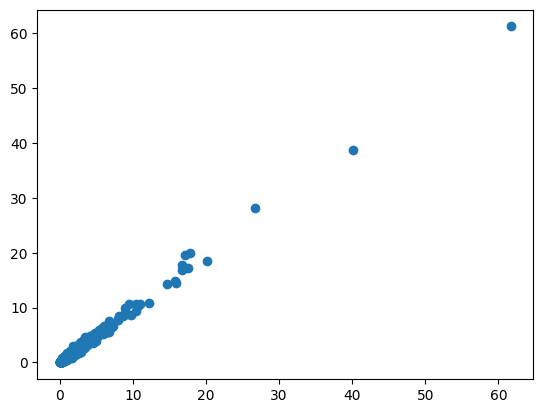

In [79]:
m = monthgen(2025, 4)
proj_months = [next(m) for _ in range(36)]


def project(params: pd.Series) -> pd.Series:
    return pd.Series(
        dict(
            zip(
                proj_months, nbinom.rvs(n=params.n, p=params.p, size=len(proj_months), random_state=rng.integers(2**32))
            )
        )
    )


projected = model_params.apply(project, axis=1)
comparison = pd.concat([counts.mean(axis=1), projected.mean(axis=1)], axis=1)
comparison.columns = ["actual", "predicted"]
plt.scatter(comparison.actual, comparison.predicted)

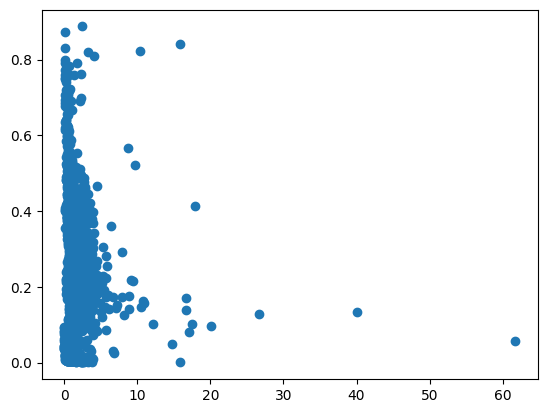

In [ ]:
# I think this needs to be *spatial* not temporal??

samples = len(counts.columns)
threshold = int(0.1 * samples)


def calc_gini(model_params: pd.Series):
    # simulated_gam=rgamma(Ntotal, shape=pars[1], rate=1)
    # scipy.stats.gamma uses shape (a) and scale (1/rate)
    # descending order by virtue of sorting on a reversed *view* of the array
    gamma_sample = np.sort(gamma.rvs(a=model_params["n"], scale=1, size=samples, random_state=rng.integers(2**32)))[
        ::-1
    ]

    # concentration=sum(sorted_gam[1:Nflag])/sum(sorted_gam)
    # Python slicing is 0-based and exclusive of the end index.
    # R's 1:Nflag corresponds to indices 0 to Nflag-1 in Python, which is [:Nflag]
    # concentration = np.sum(gamma_sample[:threshold]) / np.sum(gamma_sample)
    # print(f"Concentration (simulated): {concentration:.4f}")
    # # normalized_gam=sorted_gam/sum(sorted_gam)
    gamma_norm = gamma_sample / np.sum(gamma_sample)

    # # gini=(1/Ntotal)*(2*sum(cumsum(normalized_gam))-Ntotal-1)
    gini = (1.0 / samples) * (2 * np.sum(np.cumsum(gamma_norm)) - samples - 1)
    return gini


gini = model_params.apply(calc_gini, axis=1)
gini.name = "gini"
comparison = comparison.join(gini)

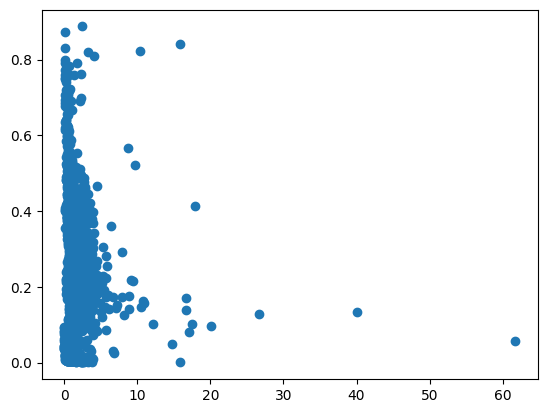

In [81]:
plt.scatter(comparison.actual, comparison.gini)

In [83]:
stats = lsoa_boundaries[["LSOA21NM", "geometry"]].merge(comparison, how="right", left_index=True, right_index=True)
stats.explore(
    "gini",
    cmap="Reds",
    tiles="CartoDB positron",
    style_kwds=dict(color="black", weight=1, opacity=0.4, fillOpacity=0.7),
)